In [3]:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import jieba as jb
import pkuseg
import re

from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

C:\Users\Administrator\AppData\Roaming\Python\Python37\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [7]:
# plt参数设置
plt.rcParams["font.sans-serif"] = ["SimHei"]  # 用来正常显示中文标签
plt.rcParams["axes.unicode_minus"] = False  # 用来正常显示符号

# 加载用户自定义词典
user_dict = ["海飞丝"]
seg = pkuseg.pkuseg(user_dict=user_dict)

df = pd.read_csv('./data/online_shopping_10_cats.csv')
df = df[['cat', 'review']]
print("数据总量: %d ." % len(df))

print(df.sample(10))

数据总量: 62774 .
       cat                                             review
59896   酒店                                   服务水平极差，话还没说完就挂电话
20448   水果  质量非常好，与京东描述的完全一致，非常满意,真的很喜欢，完全超出期望值，京东发货速度非常快，...
51384  计算机    就是本机颜色太单调。就是一种红色，如果多几种色，比如黑色.白色就太完美了。还有系统有点不太好装
48927  计算机  无点完美LED屏、接口丰富（1394、HDMI、eSATA、红外、蓝牙……）、性能强劲（3D...
47098   衣服                            线头超多，布料和想像中不一样。不建议买，真的坑
17779   水果                      苹果好脆！个头有大有小，口感好！用来榨果汁可以，甜度一般！
47768   衣服                                             不错！挺合适
60046   酒店  想不到在上海还有这样的，类似黑店。 预订之前查了评分，看来有灌水之嫌。 住在这里就一家外地人...
32268  洗发水                                   快递比较慢……到了地区还要等两天
49601  计算机        CPU强劲，拥有T400的绝大部分技术，不是SL400能比的。还有蓝牙和DVD刻录机。


In [8]:
# 数据清洗
print("在 cat 列中总共有 %d 个空值." % df['cat'].isnull().sum())
print("在 review 列中总共有 %d 个空值." % df['review'].isnull().sum())
df[df.isnull().values==True]
df = df[pd.notnull(df['review'])]

# 统计各个类别的数据量
d = {'cat':df['cat'].value_counts().index, 'count': df['cat'].value_counts()}
df_cat = pd.DataFrame(data=d).reset_index(drop=True)
print(df_cat)

在 cat 列中总共有 0 个空值.
在 review 列中总共有 1 个空值.
   cat  count
0  洗发水  10000
1   衣服  10000
2   水果  10000
3   平板  10000
4   酒店  10000
5  计算机   3992
6   书籍   3851
7   手机   2323
8   蒙牛   2033
9  热水器    574


Text(0.5, 0, '类目')

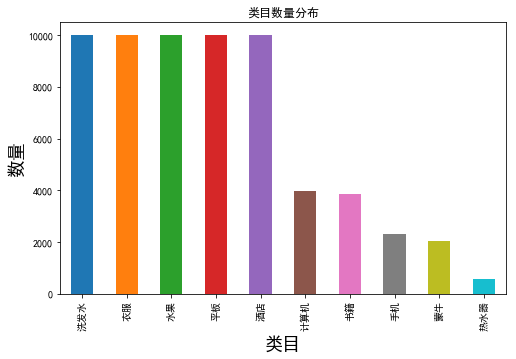

In [9]:
# 用图形化的方式再查看一下各个类别的分布
df_cat.plot(x='cat', y='count', kind='bar', legend=False,  figsize=(8, 5))
plt.title("类目数量分布")
plt.ylabel('数量', fontsize=18)
plt.xlabel('类目', fontsize=18)
# plt.show()

In [10]:
# 数据预处理
# 接下来我们要将cat类转换成id，这样便于以后的分类模型的训练
df['cat_id'] = df['cat'].factorize()[0]
cat_id_df = df[['cat', 'cat_id']].drop_duplicates().sort_values('cat_id').reset_index(drop=True)
cat_to_id = dict(cat_id_df.values)
id_to_cat = dict(cat_id_df[['cat_id', 'cat']].values)
print(df.sample(10))

print(cat_id_df)

       cat                                             review  cat_id
22504   水果                  苹果太小了，而且外表看是好的，里面居然是烂的！这品质太差，不推荐！       3
22215   水果                    这不叫苹果，应该叫mini果，太小了，就是菜市场板车卖的那种吧       3
18445   水果          宏辉果蔬 苹果 烟台红富士 12个75mm 单果约170-190g 总重约4.2斤       3
4781    平板                             东西收到，做工还可以，大气支持国货，先用用看       1
34344  洗发水                            假货，洗了严重脱头发，大家别信了，看图就知道了       4
28104  洗发水                                大品牌值得信赖，经济实惠高大上非常完美       4
41183   衣服  宝贝很好哦，给男朋友买的，反正我很喜欢，他也觉得不错，毕竟我买的他不敢说不好╮(￣▽￣")╭...       7
46872   衣服                                  质量看图，快递垃圾到爆，懒得骂了。       7
52550  计算机  使用电源适配器的时候，其发热量够惊人，有点担心会烧坏，触摸板太灵敏了，触摸板的按键确实有点硬...       8
20123   水果                        产品质量不错，送货很及时，还可以开发票，下次继续购买。       3
   cat  cat_id
0   书籍       0
1   平板       1
2   手机       2
3   水果       3
4  洗发水       4
5  热水器       5
6   蒙牛       6
7   衣服       7
8  计算机       8
9   酒店       9


In [11]:
# 定义删除除字母,数字，汉字以外的所有符号的函数
def remove_punctuation(line):
    line = str(line)
    if line.strip() == '':
        return ''
    rule = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5]")  # 正则
    line = rule.sub('', line)
    return line


def stopwordslist(filepath):
    stopwords = [line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()]
    return stopwords


# 加载停用词
stopwords = stopwordslist("./data/chineseStopWords.txt")

In [12]:
#删除除字母,数字，汉字以外的所有符号
df['clean_review'] = df['review'].apply(remove_punctuation)
print(df.sample(10))
# 我们过滤掉了review中的标点符号和一些特殊符号，并生成了一个新的字段 clean_review。
# 接下来我们要在clean_review的基础上进行分词,把每个评论内容分成由空格隔开的一个一个单独的词语。

       cat                                             review  cat_id  \
27634  洗发水                                  这个牌子应该可以，刚收到货还没用。       4   
6892    平板                                    一直都是买的他们家的，确实好用       1   
7849    平板                                        感觉不错用一段时间再说       1   
27037  洗发水                                 品质保证质量很好下次再购买，送货快，       4   
24650   水果                                  一般般，不太好，反正是乱七八糟的买       3   
14215   手机  看看它的顶极配置，性价比很高。双26万色屏，顶极配置，颜色清晰，富有极强的层次感。支持SD扩...       2   
34684  洗发水                                 没有赠品，发票也没有，最差的一次网购       4   
56651   酒店  在甘肃能有这样一个酒店实属不易，比阳光大厦好很多，无论从硬件设施还是服务水平都一流，建议：游...       9   
36625  热水器  发货速度超级快！晚上下单，一早就送货安装^_^试用一周，超级好。 客服人员超级有耐心解答每个...       5   
44553   衣服  最气人的一次网购。电话打过来推荐大一号的。结果给邮了大三号的。如大衣一样。纯是骗子。***邮...       7   

                                            clean_review  
27634                                    这个牌子应该可以刚收到货还没用  
6892                                      一直都是买的他们家的确实好用  
7849               

In [13]:
#分词，并过滤停用词
# df['cut_review'] = df['clean_review'].apply(lambda x: " ".join([w for w in list(jb.cut(x)) if w not in stopwords]))
df['cut_review'] = df['clean_review'].apply(lambda x: " ".join([w for w in seg.cut(x) if w not in stopwords]))
print(df.head())

  cat                                             review  cat_id  \
0  书籍  ﻿做父母一定要有刘墉这样的心态，不断地学习，不断地进步，不断地给自己补充新鲜血液，让自己保持...       0   
1  书籍  作者真有英国人严谨的风格，提出观点、进行论述论证，尽管本人对物理学了解不深，但是仍然能感受到...       0   
2  书籍  作者长篇大论借用详细报告数据处理工作和计算结果支持其新观点。为什么荷兰曾经县有欧洲最高的生产...       0   
3  书籍  作者在战几时之前用了＂拥抱＂令人叫绝．日本如果没有战败，就有会有美军的占领，没胡官僚主义的延...       0   
4  书籍  作者在少年时即喜阅读，能看出他精读了无数经典，因而他有一个庞大的内心世界。他的作品最难能可贵...       0   

                                        clean_review  \
0  做父母一定要有刘墉这样的心态不断地学习不断地进步不断地给自己补充新鲜血液让自己保持一颗年轻的...   
1  作者真有英国人严谨的风格提出观点进行论述论证尽管本人对物理学了解不深但是仍然能感受到真理的火...   
2  作者长篇大论借用详细报告数据处理工作和计算结果支持其新观点为什么荷兰曾经县有欧洲最高的生产率...   
3  作者在战几时之前用了拥抱令人叫绝日本如果没有战败就有会有美军的占领没胡官僚主义的延续没有战后...   
4  作者在少年时即喜阅读能看出他精读了无数经典因而他有一个庞大的内心世界他的作品最难能可贵的有两...   

                                          cut_review  
0  做 父母 一定 刘墉 心态 不断 学习 不断 进步 不断 补充 新鲜 血液 保持 颗 年轻 ...  
1  作者 真 英国人 严谨 风格 提出 观点 进行 论述 论证 物理学 了解 深 仍然 感受 真...  
2  作者 长篇大论 借用 详细 报告 数据 处理 工作 计算 支持 新 观点 荷兰 曾经县 欧洲...  
3  作者 战几时 之前 拥抱 令 人 叫绝 日本 没有 战败 会 

In [14]:
"""
接下来我要计算cut_review的 TF-IDF的特征值，TF-IDF（term frequency–inverse document frequency）是一种用于
信息检索与数据挖掘的常用加权技术。TF意思是词频(Term Frequency)，IDF意思是逆文本频率指数(Inverse Document Frequency)。
TF-IDF是在单词计数的基础上，降低了常用高频词的权重,增加罕见词的权重。因为罕见词更能表达文章的主题思想,比如在一篇文章中出现
了“中国”和“卷积神经网络”两个词,那么后者将更能体现文章的主题思想,而前者是常见的高频词,它不能表达文章的主题思想。所以“卷积
神经网络”的TF-IDF值要高于“中国”的TF-IDF值。这里我们会使用sklearn.feature_extraction.text.TfidfVectorizer方法来
抽取文本的TF-IDF的特征值。这里我们使用了参数ngram_range=(1,2),这表示我们除了抽取评论中的每个词语外,还要抽取每个词相邻
的词并组成一个“词语对”,如: 词1，词2，词3，词4，(词1，词2)，(词2,词3)，(词3，词4)。这样就扩展了我们特征集的数量,有了丰富
的特征集才有可能提高我们分类文本的准确度。参数norm='l2',是一种数据标准划处理的方式,可以将数据限制在一点的范围内比如说(-1,1)
"""
tfidf = TfidfVectorizer(norm='l2', ngram_range=(1, 2))
features = tfidf.fit_transform(df.cut_review)
labels = df.cat_id
print(features.shape)
print('-----------------------------')
print(features)


(62773, 594639)
-----------------------------
  (0, 440625)	0.09100733671790184
  (0, 322072)	0.08775739703661746
  (0, 229567)	0.07734320542579194
  (0, 53108)	0.09100733671790184
  (0, 218266)	0.08775739703661746
  (0, 52715)	0.08775739703661746
  (0, 421109)	0.08775739703661746
  (0, 40482)	0.09100733671790184
  (0, 386894)	0.09100733671790184
  (0, 505807)	0.09100733671790184
  (0, 275074)	0.08775739703661746
  (0, 133540)	0.09100733671790184
  (0, 408872)	0.09100733671790184
  (0, 531939)	0.09100733671790184
  (0, 536178)	0.09100733671790184
  (0, 342936)	0.09100733671790184
  (0, 93320)	0.09100733671790184
  (0, 537258)	0.09100733671790184
  (0, 74281)	0.09100733671790184
  (0, 370934)	0.09100733671790184
  (0, 288505)	0.09100733671790184
  (0, 347195)	0.09100733671790184
  (0, 70651)	0.09100733671790184
  (0, 217005)	0.09100733671790184
  (0, 408891)	0.08775739703661746
  :	:
  (62772, 550963)	0.027683897082059435
  (62772, 280691)	0.03842589515908136
  (62772, 461169)	0.0396918

In [11]:
"""
我们看到我们的features的维度是(62773,657425),这里的62773表示我们总共有62773条评价数据，657425表示我们的特征数量
这包括全部评论中的所有词语数+词语对(相邻两个单词的组合)的总数。下面我们要是卡方检验的方法来找出每个分类中关联度最大的
两个词语和两个词语对。卡方检验是一种统计学的工具,用来检验数据的拟合度和关联度。在这里我们使用sklearn中的chi2方法。
"""

N = 2
for cat, cat_id in sorted(cat_to_id.items()):
    features_chi2 = chi2(features, labels == cat_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(cat))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

"""
我们可以看到经过卡方(chi2)检验后，找出了每个分类中关联度最强的两个词和两个词语对。这些词和词语对能很好的反映出分类的主题
"""

MemoryError: 

In [15]:
# 朴素贝叶斯分类器
X_train, X_test, y_train, y_test = train_test_split(df['cut_review'], df['cat_id'], random_state=0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [16]:
# 保存模型
joblib.dump(clf, "naive_bayes_train_model.m")
# 加载模型
# clf = joblib.load("naive_bayes_train_model.m")


['naive_bayes_train_model.m']

In [17]:
def myPredict(sec):
    # 预测函数
    new_sec = remove_punctuation(sec)
    print(new_sec)
    format_sec=" ".join([w for w in seg.cut(new_sec) if w not in stopwords])
    pred_cat_id=clf.predict(count_vect.transform([format_sec]))
    print(id_to_cat[pred_cat_id[0]])

In [18]:
myPredict("感谢京东自营产地直采。你们把握质量关。第三次购买")
myPredict("头屑越洗越多，下次再也不买了。")


感谢京东自营产地直采你们把握质量关第三次购买
水果
头屑越洗越多下次再也不买了
洗发水


In [20]:

"""
接下来我们尝试不同的机器学习模型,并评估它们的准确率，我们将使用如下四种模型:
Logistic Regression(逻辑回归)
(Multinomial) Naive Bayes(多项式朴素贝叶斯)
Linear Support Vector Machine(线性支持向量机)
Random Forest(随机森林)
"""
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


C:\Users\Administrator\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [21]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.594728
1,RandomForestClassifier,1,0.593899
2,RandomForestClassifier,2,0.562565
3,RandomForestClassifier,3,0.467936
4,RandomForestClassifier,4,0.512110
5,LinearSVC,0,0.872501
6,LinearSVC,1,0.877748
7,LinearSVC,2,0.858144
8,LinearSVC,3,0.832550
9,LinearSVC,4,0.834608


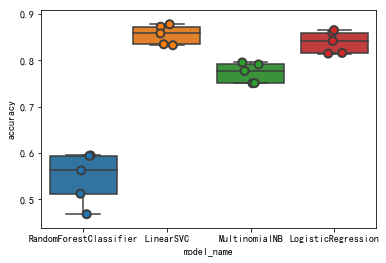

'\n从可以箱体图上可以看出随机森林分类器的准确率是最低的，因为随机森林属于集成分类器(有若干个子分类器组合而成)，\n一般来说集成分类器不适合处理高维数据(如文本数据),因为文本数据有太多的特征值,使得集成分类器难以应付,另外三个分类器的\n平均准确率都在80%以上。其中线性支持向量机的准确率最高。\n'

In [22]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()
"""
从可以箱体图上可以看出随机森林分类器的准确率是最低的，因为随机森林属于集成分类器(有若干个子分类器组合而成)，
一般来说集成分类器不适合处理高维数据(如文本数据),因为文本数据有太多的特征值,使得集成分类器难以应付,另外三个分类器的
平均准确率都在80%以上。其中线性支持向量机的准确率最高。
"""

In [23]:
print(cv_df.groupby('model_name').accuracy.mean())


model_name
LinearSVC                 0.855110
LogisticRegression        0.839418
MultinomialNB             0.773005
RandomForestClassifier    0.546248
Name: accuracy, dtype: float64


In [24]:
# 模型的评估
# 下面我们就针对平均准确率最高的LinearSVC模型，我们将查看混淆矩阵，并显示预测标签和实际标签之间的差异。

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# 训练模型
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index,
                                                                                 test_size=0.33, stratify=labels,
                                                                                 random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


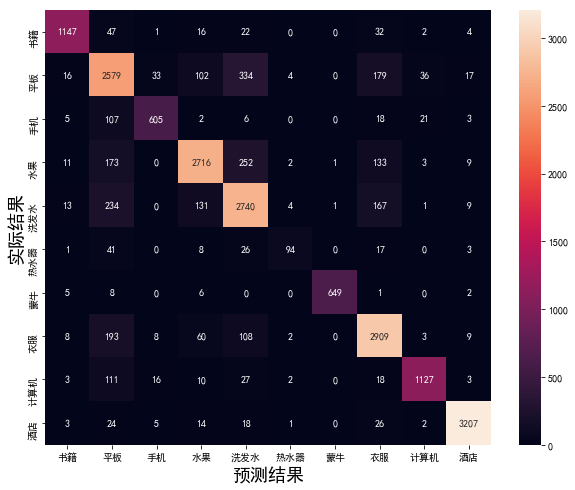

In [25]:
# 生成混淆矩阵
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=cat_id_df.cat.values, yticklabels=cat_id_df.cat.values)
plt.ylabel('实际结果', fontsize=18)
plt.xlabel('预测结果', fontsize=18)
plt.show()

In [26]:
"""
混淆矩阵的主对角线表示预测正确的数量,除主对角线外其余都是预测错误的数量.从上面的混淆矩阵可以看出"蒙牛"类预测最准确,
只有一例预测错误。“平板”和“衣服”预测的错误数量教多。

 多分类模型一般不使用准确率(accuracy)来评估模型的质量,因为accuracy不能反应出每一个分类的准确性,因为当训练数据不平衡
(有的类数据很多,有的类数据很少)时，accuracy不能反映出模型的实际预测精度,这时候我们就需要借助于F1分数、ROC等指标来评估模型。

下面我们将查看各个类的F1分数.
"""
from sklearn.metrics import classification_report

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=cat_id_df['cat'].values))

accuracy 0.8579358949604171
              precision    recall  f1-score   support

          书籍       0.95      0.90      0.92      1271
          平板       0.73      0.78      0.76      3300
          手机       0.91      0.79      0.84       767
          水果       0.89      0.82      0.85      3300
         洗发水       0.78      0.83      0.80      3300
         热水器       0.86      0.49      0.63       190
          蒙牛       1.00      0.97      0.98       671
          衣服       0.83      0.88      0.86      3300
         计算机       0.94      0.86      0.90      1317
          酒店       0.98      0.97      0.98      3300

    accuracy                           0.86     20716
   macro avg       0.89      0.83      0.85     20716
weighted avg       0.86      0.86      0.86     20716



In [27]:
"""
从以上F1分数上看,"蒙牛"类的F1分数最大(只有一个预测错误)，“热水器”类F1分数最差只有66%，
究其原因可能是因为“热水器”分类的训练数据最少只有574条,使得模型学习的不够充分,导致预测失误较多吧。

下面我们来查看一些预测失误的例子,希望大家能从中发现一些奥秘,来改善我们的分类器。
"""

from IPython.display import display

for predicted in cat_id_df.cat_id:
    for actual in cat_id_df.cat_id:
        if predicted != actual and conf_mat[actual, predicted] >= 6:
            print("{} 预测为 {} : {} 例.".format(id_to_cat[actual], id_to_cat[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['cat', 'review']])
            print('')


平板 预测为 书籍 : 16 例.


,cat,review
6627,平板,唯一只是操作习惯不同（各人感觉哈 ）
5241,平板,不焦虑就可能会尽可能
6056,平板,黑变大，俺其他的嘛，一般般什么技能啊，我靠翻译都分不清楚
7495,平板,给闺女玩宝宝巴士的，还不错
4602,平板,拿到手感到很惊讶，很大，很漂亮，相信它
4427,平板,买给爸爸的 主要看小说用。还算好用
5925,平板,挺好用，一本书大小适合外出携带，只是包装里没有操作说明，让我这个第一次用平板的人上网查了好半...
11768,平板,买下来后因为工作忙一直没怎么用，二十天内就用了几次，刚到手的时候就发现有轻微跳屏现象，当时没...
7190,平板,主要卖给宝宝看动画片的，以前的那个2年坏2次，这次买个好点的看看。
9699,平板,嗯嗯，不怎么样，买错了



水果 预测为 书籍 : 11 例.


,cat,review
16309,水果,吃上两口好爽甜，买了两箱慢慢吃。
16589,水果,古古怪怪方法反反复复唱个歌古古怪怪古古怪怪
25944,水果,冻了冻了冻了，这东西真是碰运气了。
22012,水果,实在不怎么样？建议大家在当地买就可以了！不值得
18303,水果,我们的生活方式。我觉得自己是一个人在一起了
17530,水果,没有，前几次买的好总是，能遇到，里面是烂的
20558,水果,精彩双十一，天天好心情，虽然花了钱，但是就是值。
25472,水果,太苦了，估计全部都只有一个结局:扔扔扔。
19458,水果,还行！要是给京豆的话我也许还会多写几个字……
23035,水果,酸的，和一次买的，绝对不是自家的！



洗发水 预测为 书籍 : 13 例.


,cat,review
34935,洗发水,感觉像假得似的，没有在现实里买的好
28248,洗发水,听说是乌龟油，买来发现，上当了，不是剧本上写的
26920,洗发水,梦想破灭 就像上天给他开的玩笑 和自己做的一场白日梦 但是又不忍放弃当初的梦想 从在梦想的最...
26385,洗发水,在这个世界上，人与人之间，无非就是，一份缘，一份爱，一份情，一份心，一份真。擦肩而过的，叫路...
33831,洗发水,这个不好，真的，宝宝用了会给皮肤带来伤害！
35774,洗发水,不值得 电话的废话都觉得好的
35031,洗发水,一般般总觉得有点像假的
35806,洗发水,-/、何须今年的饭都没了。我们的生活方式，我们的生活方式，我们的生活方式
28413,洗发水,人生为惑，命寻解惑，无惑无生，命中需惑，解之。
34954,洗发水,好喜欢公司附近京东的快递大哥~ 昨晚第一次用，味道不、是、很、好，但是控油效果貌似挺好...



衣服 预测为 书籍 : 8 例.


,cat,review
47713,衣服,一边一边玩去1
40629,衣服,很喜欢，很好，很适合，好东西，介绍给大家，。。好，好，好
41804,衣服,很好的例子宫锁珠帘幽默默默默默默默默默好好好
48306,衣服,其实不怎么样
41723,衣服,今天，幼儿园搞活动，共有三个小班，每个班出场时，要喊口号：小一班喊的口号是：“小一，小一，勇...
48586,衣服,哎，真系觉得被骗了，实在太差了，很薄！
46472,衣服,十七号到三十号如今这时代也需要如此长时间才能拿到货？
48369,衣服,这什么意思，这货都给你们发过去8天了你们是换还是不换，要不把钱退了



书籍 预测为 平板 : 47 例.


,cat,review
2458,书籍,一般一般一般一般一般一般一般一般一般
3617,书籍,当初无意在电视上看到对于丹的采访，满怀希望地买她的书看。看后觉得与电视中的讲演相距甚远！失望！
2469,书籍,一般！！一般！！一般！！一般！！一般！！一般！！一般！！一般！！一般！！一般！！一般！！一般...
3511,书籍,"废话多,感觉不是很好.不是很系统很专业,可操作性也不强."
1536,书籍,孩子爸打来电话，儿子竟然对他说：爸爸你知道了，这几天我每天都在看《我想念你》，你有没有想念我...
2371,书籍,有几张图像不清晰，真是不敢想象！
2437,书籍,一个特殊的年代，一段刻骨的爱恋，一种压抑的痛，山楂树下的爱不单只是爱……
3505,书籍,概括起来，观点还不错。可是语句啰嗦拖沓到极点，一个问题用相同的语句重复N遍。
2916,书籍,收到后，发现光盘上尽然有道裂缝，已联系dangdang退货，建议dangdang换个快递吧。
3431,书籍,还没买的朋友...就不用买了 ......



手机 预测为 平板 : 107 例.


,cat,review
14051,手机,1.外形圆滑，比较吸引年轻人的目光2.屏幕的分辨率有了提高，但仍然使用的是4096色，还是遗...
16121,手机,"电池充完了电连手机都打不开.简直烂的要命.真是金玉其外,败絮其中!连5号电池都不如"
14203,手机,特别之处就是外屏幕的闪电屏幕
14867,手机,上周末给MM买了个红色的，做工很不错，很有金属质感，感觉像DC而不是手机，MM超喜欢。电池还...
14097,手机,对于我的VS2所有功能我都很满意，真没什么可以挑剔的，待机时间不用多说，这个机子省就一个字，...
15666,手机,"太烂了,经常黑屏,还死机."
16084,手机,我这个手机还是和几位朋友在省城南昌买，当时在几百种手机中挑选出来的，我觉得这款手机款式挺新颖...
15439,手机,屏幕易进灰、滑盖易松动、按键松软无手感，根本没有N6280出色，不建议购买。
13937,手机,都很好.
14973,手机,机子造型可爱！那个镜子也算实用，上班起晚了，路上拿出来偷偷照照！机子还算轻，一般放在口袋里就...



水果 预测为 平板 : 173 例.


,cat,review
23792,水果,极差！吃了三次拉了三次肚子，没有造谣，即使赔了钱也太差劲了！！！不知道对身体有没有影响，体验很差。
18443,水果,包装还很好，看起来很红很诱人，拿了两个准备去公司吃，就是有点小
16234,水果,东西很好，京东送货很快，物美价廉
16696,水果,速度快，要加钱，速度快，要加钱，，，，
23156,水果,不知道是送货问题还是采摘太久，收到时全坏了，一个没剩
20192,水果,给女票买的，挺不错的，就是这次发货有点慢
22904,水果,我真的是连一颗心都不想给，说好的两天到货，没到。最后就不了了之，都没个答复，再也不相信这家了...
23839,水果,垃圾 真的不想说什么 拿回来有一个还是坏的 能把胆给苦出来！谁买谁骂娘 立贴为证！！！
24442,水果,太差，烂1半，问了半天没人解决，
19766,水果,产品还不错，主要是评论可以得积分，这个挺好的，所以多发几个字，多赚点积分，产品还不错，主要是...



洗发水 预测为 平板 : 234 例.


,cat,review
31083,洗发水,好好6666666666666666
33412,洗发水,果断差评，送的风机呢？？忽悠人呢？？
29889,洗发水,京东的速度从来没有失望过，发货送货速度很快，包装完好，谢谢一早就为我送货的快递大哥，很满意的...
32119,洗发水,昨天才买的，今天一看就便宜了*不是欺骗消费者吗？京东太垃圾了！差评差评差评
29568,洗发水,东西挺好的，京东物流还可以，可能下雨就慢了点。
35230,洗发水,我奶奶说就是可能是娜娜宝宝你手机上班
30266,洗发水,东西很好老婆很喜欢 值得购买的产品 物流很快早上七点下的单下午五点多就拿到货了 非常满意的一...
26932,洗发水,感觉东西不错，比较喜欢，一直相信京东
35942,洗发水,垃圾！！喷了之后超级难吸收！！塑料瓶看似厚实，一个手滑掉下去就裂了！！之前在别家买的施华蔻精...
28740,洗发水,还行吧，感觉可以满意。好评！



热水器 预测为 平板 : 41 例.


,cat,review
36548,热水器,很好 特地用了几天才来评价的
36639,热水器,挺好的，今天用了。
36495,热水器,品牌的东西，值得信任。
36339,热水器,非常好
36375,热水器,非常满意
36338,热水器,很不错的产品、这个已经是第五个了。跟朋友买的
36428,热水器,不错，没几天就到了，很效率。宝贝大气美观，而是正品，很是喜欢
36455,热水器,好用
36501,热水器,质量挺好的
36214,热水器,非常好用，全5分！



蒙牛 预测为 平板 : 8 例.


,cat,review
37064,蒙牛,终极一班的片头大大的飞轮海3个字，但当时并没想过这个组合什么意义，后来在搜索辰亦儒的综艺视频...
36892,蒙牛,因为今天在电视上看蒙牛风云榜，主持有奖回答问题，奖品居然是昌珉亲笔签名catch me 专辑...
37697,蒙牛,特仑苏</Feature
38535,蒙牛,还是觉得天友的大红枣酸麦好喝，伊利的不够香，蒙牛的太甜，雪宝的太酸……
37708,蒙牛,安心了 大蒙牛可以颁个海外最受欢迎新人组合什么的 姐姐还想看看你们
37702,蒙牛,我喜欢demom制造的蒙牛奶
37747,蒙牛,蒙牛人多的可怕…
38754,蒙牛,如果是真的就卸载一切360软件



衣服 预测为 平板 : 193 例.


,cat,review
47022,衣服,看不懂啊 发错快递 快递不到我这里 我给快递打电话一直打不通 真的坑 问客服呢 一直发笑脸 看不懂
47998,衣服,不满意，货不真，价不实
47214,衣服,先不说东西就说商家服务吧，我记得我是2号晚上下单的，结果5号还没发货，然后我像商家反映，客服...
45172,衣服,只有快倒闭的商家才会用快倒闭的申通，双十一当天的订单，26号才收到货，中间联系商家四五次都是...
45321,衣服,差 很差 非常差 除了差 没别的
46951,衣服,本来买小了换了好久，有条裂缝
45337,衣服,很不满意。。。。。。。。。。。。。。。。。。。。。。
42879,衣服,手感不错，速度蛮快的，下次接着买
47502,衣服,就这物流，就这态度，呵呵呵，本来不想要，为了这一个差评，值了。
47062,衣服,我要让你们知道五星不是那么好拿的，，，不能让你们骄傲！



计算机 预测为 平板 : 111 例.


,cat,review
52347,计算机,比新o贵80多~~比yixun贵100~~~但我比较信任京东~~~而且在天津还有自提~~贵1...
52497,计算机,黑色的表面指纹很明显，屏幕色温挺高，偏色挺大，而且好像不能调？似乎只能调屏幕整亮度，不接交流...
52191,计算机,但是降价也太快了吧，我订购时4299，才不到一周呢，又降了100多，这对消费者太不公平了。虽...
48843,计算机,买之前一直在12和14寸间犹豫，太重或屏幕太小 可是买了后没有后悔，非常喜欢
50843,计算机,送来就是坏的，点不亮，也怪我粗心没试就刷卡收货了。搞得我还要自己去话说维修点检测，然后才给换...
52566,计算机,没多久就又降了100元，没有num lock显示。稍稍有点点重，比想象中。那个那个存储的宣传...
51815,计算机,外形显笨重，T400都是这样的吧？ 另外此型号没有读卡器，但是有两个卡槽可以装express...
52138,计算机,屏的显示效果好象不大好，不知道是才拿到不会调还是其它问题，内存是DDR2 667的插在内存槽...
49021,计算机,送了那么多东西，还用了-100的卷，好！！！！！！！！！！！！1
51904,计算机,速度一般。而且应该是适合年轻人用，因为字体还算是比较小的。给老爸用就看不清了。



酒店 预测为 平板 : 24 例.


,cat,review
53910,酒店,"可以, 不错, 好呀,---- 就是有点贵呀"
60943,酒店,非常非常差
60755,酒店,一般般还
55695,酒店,很不错的感觉，不过只住了一天。很有品位。
60844,酒店,一般般不是很好
60942,酒店,网路很差
61890,酒店,好吵！不停的有杂音！
58089,酒店,一般啦！
61026,酒店,设施旧了，早晨结帐打发票死机，也要更新一下了，到最后我的发票寄给我。晕!！
59730,酒店,差的很，建议推出携程网推荐用户。强烈建议！！！！！！！！！！！！！！！



平板 预测为 手机 : 33 例.


,cat,review
8211,平板,总体机很可以就是手写发消息字写不完整就跳频
11359,平板,买回来用了一星期就死机了，特约维修站检修下来说是显示器和排线坏了，我晕。
10721,平板,显示屏很差
7272,平板,照相效果不好，照出的像不真
10374,平板,还好，就是通话质量不太好有回音，上网卡卡卡，比较不man?y
10592,平板,随时死机，哎！便宜没好货
4082,平板,非常棒，解码能力很强，什么都能播放，很适合我，观影效果极佳，电量也大
13332,平板,拍照效果很差，不清晰。。。。。。。
4269,平板,送人的，性价比不错，就是各方面表现一般，拍照和容量太捉急
7563,平板,待机时间长，用起来还可以



衣服 预测为 手机 : 8 例.


,cat,review
44217,衣服,太差了！大家小心
47357,衣服,售后服务太差
39645,衣服,刚买，还没穿，其它看着没啥缺点，不错。
45083,衣服,不喜欢，不值这个价钱
40318,衣服,已经买了很多次了，很多朋友让我给他带
48046,衣服,质量差的无法去评价
47227,衣服,质量很糙，牌子连产地都不知道，只有一个英文字母
47237,衣服,货到了没收到短信



计算机 预测为 手机 : 16 例.


,cat,review
50162,计算机,1、外观精致，做工优异。发货速度快 2、led屏幕亮丽，可视角度大 3、键盘布局还可以，就是...
49533,计算机,最大的优点就是电池待机时间相对来说比较长！做工十分精致，很小很轻便，携带方便！风扇声音很小，...
49852,计算机,1、外观时尚、精致； 2、显示屏可旋转、手写，感觉很酷； 3、迷你遥控器操作方便； 4、配置...
50132,计算机,比较便携，至少比我的FZ-35轻，混合存储很有创意，电池容量很大。
50003,计算机,性价比不错，功能全面，而且没有亮点哦~~~~哇哈哈~~~~~~ 服务也很到位，1天就到了，不...
49344,计算机,外观还是挺时尚的、性价比较高！设计挺时尚的，真机比照片要漂亮些，值得推荐！
52506,计算机,第一，一插入无线上网卡（usb接口）就自动关机；第二，待机时间没有宣称的那么长久；第三，比较...
52765,计算机,光盘高速读取时，有些微微发抖的声音； 添加内存不方便，要卸下整个2/3的后盖，拧10个螺丝钉
49648,计算机,小巧，漂亮！上网，文本和照片编辑速度还算理想。屏幕和键盘的大小还好！
50642,计算机,"小巧实用,外观好看;而且系统盘所在的区和其它区已经分开,尽管只有两个区,不过已经足够了"



书籍 预测为 水果 : 16 例.


,cat,review
2987,书籍,气人、这书评论过N次了、还说我没评论过、
2321,书籍,再也不想来这里买东西了，太慢了，10天还没收到，很失望
3437,书籍,贵公司14号发出，为什么到今天还没收到呢？今天已经是26号了.12天了，还没收到书。
2421,书籍,"以后买韩国佬的东西先三思再四思,思过以后不要买."
2422,书籍,以后还是少买这样的书，名人效应啊
2999,书籍,披着文革外皮的《第一次亲密接触》……
2045,书籍,请问：有些字打错了，我怎么样才可以回去编辑一下啊？
2463,书籍,一般般而已没看出有什么哲理呀?失望ING...............
1799,书籍,超喜欢五官的，五官好可怜，虽然她一心想往上爬，但是她的心很正直，人不犯她，她也不犯人。应天临...
2562,书籍,"我以为是武汉方言版,或者有配音,结果基本上是哑剧,里面总共没插几句话!"



平板 预测为 水果 : 102 例.


,cat,review
6440,平板,看起来不错，希望自己能抽中
9307,平板,送来物品有损坏，太信任京东，嗨，失败
7756,平板,非常的好 服务很到位
9259,平板,想骂脏话，屏蔽！
7969,平板,和此卖家交流，不由得精神为之一振，自觉七经八脉为之一畅，我在京东买了这么多年，所谓阅商无数，...
8685,平板,华威，中国的骄傲，太好啦，质量这么棒，好过苹果
7790,平板,非常好，一次买了十二个，做为销售队伍的奖品，很是高大上！
6016,平板,刚到手，商家很用心用了一个大箱子，只为装这幺小的一个板。
6838,平板,给自己买的，比苹果手机好多了，价格也合适
9548,平板,买个**东西！真的只能看电视！玩王者荣耀 呵呵 开始不相信现在信了 不如苹果2688不如果苹...



洗发水 预测为 水果 : 131 例.


,cat,review
35394,洗发水,请在配货时检查一下好吗？痕迹都是干的，肯定不是运输时候造成的
31108,洗发水,京东的比超市的优惠太多了，快递也给力，一直喜欢在京东上买东西
32976,洗发水,小瓶犬小。洗着没什么泡沫。有着半假样子
32496,洗发水,写着4.9折 到货才知道根本不是 我每次买大瓶的才60多 这比我买的小多了 也就是正常价 打...
35834,洗发水,很严肃得投诉包装。请看晒图，如此漠视顾客。没有塑封，没有气泡膜，基本的防震都没有。再不改进，...
26881,洗发水,价格合适，包装还挺不错，活动plus会员买的，更优惠。
31788,洗发水,买六瓶发三瓶 京东售后处我提交多次申请查订单 没 回复 实在愤恨 差评
27467,洗发水,京东自营商品送货速度就是快！服务态度也很好！商品质量不错！第二次购买了，自己用着还可以吧！
33526,洗发水,明明小瓶的送两瓶，结果只送了一瓶，请问京东还有一瓶去哪里了？
30943,洗发水,便宜、快捷、大爱京东！除了买买买我还能怎样表达我浓浓的爱意！



热水器 预测为 水果 : 8 例.


,cat,review
36438,热水器,卖家服务台好了一流的服务噢 ，真的很好，大家赶紧来买吧。选别家你们会后悔噢，这家认真负责呢。
36407,热水器,再次购买，好评！！！
36434,热水器,不错，已经在用了
36422,热水器,电热水器非常好，性价比高，顾客买的放心。
36313,热水器,刚收到货还没有装，看着换不错
36675,热水器,已收到货好几天，都还没来得及拆开看下。浴室还没装修好，不知道能不能用，会不会有问题。
36536,热水器,第三次在这家店买了，挺不错！
36611,热水器,看上去不错，还没装。



蒙牛 预测为 水果 : 6 例.


,cat,review
37531,蒙牛,#没品胡扯# &quot;炒肝、爆肚、灌肠、炸酱面、豌豆黄.......&quot; 其实每...
37666,蒙牛,支持蒙牛還是已改變口味另選牌子？
37556,蒙牛,陈信宏真是贴心呐，他给了迷妹男朋友一条生路，买不起奥迪ss演唱会门票送给女朋友，没关系那就买...
37066,蒙牛,刚刚转的冰淇淋微博让我想起了快本。顺便科普个 快本时某人吃的第几个冰淇淋我忘了。。好像是第一...
38311,蒙牛,望蒙牛伊利杀入国际市场也定坑爹价(￣▽￣)
37511,蒙牛,昂贵的蒙牛莱慕冰淇淋月饼，超好吃！



衣服 预测为 水果 : 60 例.


,cat,review
41394,衣服,很满意，第二次购买，以后还会来
46767,衣服,质量太差 以后绝不购买 这黑线我还能穿出去？
45029,衣服,差！差！差！差！差！差！差差！差差差！差差差差！差差差！差差差！差差差！CVC擦擦！擦擦擦！...
44635,衣服,快递慢死了 啊啊啊啊啊啊啊
43327,衣服,应该是冒牌货，京东只有自营才可靠
47941,衣服,第一次给差评。真的是第一次。真墨迹。
48748,衣服,送货太慢，服务太差，送快递的真差，差差差差差差差差差差差差差、差差差差差差差差差差差差差差差...
46055,衣服,才没穿几次，就已经烂成这样了么？只能用四个字来形容了，粗制滥造
39057,衣服,很好看！包邮'京东速度非常快，下面一定再来！嗯嗯
45791,衣服,要的是中弹，收到的就是微弹



计算机 预测为 水果 : 10 例.


,cat,review
51712,计算机,耗电太快了，有些驱动装不上 价格降的快，自己买的也不是时机，就差一两天 声明本人签收，送货来...
50585,计算机,送货超级快，周五下班前下的订单，周六上午就送到家了，赞一个哈~~体积比较小
49069,计算机,笔记本不错，京东不够厚道，钻石抢的和现在促销价没差几分，这不是忽悠我们钻石一族吗？？？
49988,计算机,外观还算时尚。键盘还是巧克力型的，像苹果那种方的，键帽，平的。
51504,计算机,稍稍有一点点厚；U口有两个在左侧一个在左后，连上鼠标线有点短。
49124,计算机,白色的10寸上网本里面，就三星的这一款的漆膜最漂亮。 送给女朋友确实是一个不错的选择。
50205,计算机,这是帮办公室里同事买的，完善屏，非常的不错，我是京东老顾客了，对京东的服务相当的满意。
50574,计算机,本职工作用起来还是不错的，待机时间很满意，Linux系统用起来还有点新鲜，做工和预期的一样好
51138,计算机,京??次的包??有包好，里面的?西都?了，比上次?音箱的包?差多了，清洁?直接?了．???心...
51871,计算机,刚买不到一周，现在报价已经降了300。我是5799买的 。挺恶心人的 。



酒店 预测为 水果 : 14 例.


,cat,review
61047,酒店,完全不够它所标的星级
62002,酒店,差到一定程度了 不如一个好的二星或没星的宾馆呢
61153,酒店,外面看不错里面太陈旧，以后不会再住了
62071,酒店,没冰箱，没浴袍，说是不是主楼什么都没，差
61676,酒店,总之以后不会再住了
60195,酒店,"可以用一句话来描述当时的心情,太失望了."
60093,酒店,是我住过最差的橘子
58481,酒店,一个字:差
60042,酒店,真心不好，价格高不说了，居然连地毯都是发霉的
60473,酒店,在这里找不到客人的感觉和尊严，有点像80年代的国营商店，你爱来不来、也没求你来、店里不少你一...



书籍 预测为 洗发水 : 22 例.


,cat,review
3186,书籍,空尤其是三立电视台女主播做的序尤其无趣像是硬凑那么多字
3392,书籍,很怀疑书的质量，其中有几页居然没有页码
2191,书籍,这是我帮同学订的，之前我已经买过一本，挺不错的。
2739,书籍,"完全不使用,白干白买,根本没有仔细看"
2394,书籍,因为突然觉得自己接受不了这样的书，所以没打开，还是新的啊
3475,书籍,"刚买的书,晚上想好好看看,发现里面有好多页印倒了.好郁闷!我想换一下?"
3693,书籍,不知道是我没用 还是书没用总之 没用
2076,书籍,对于次级债的解说，可以参考如下网站：http://abeautifulmind.blog.h...
3089,书籍,没有什么太大的感觉，读了一半就放下了
2163,书籍,这真是一本好书，而且价钱又便宜。真好呀！



平板 预测为 洗发水 : 334 例.


,cat,review
4804,平板,效果不错，老婆挺喜欢她，没有重影
4839,平板,一直京东买，很好，送货上门，快递又快，服务好，赞一个。
8355,平板,发货快，第二天收到，挺好用的。
13560,平板,货不对版还是要到实体店比较好。
5244,平板,不错，好评！如果价格再低一些就好了
10472,平板,妈的 刚买完就降价
11770,平板,态度很不好，我收货发现外包装破损要求拆开包装验货被快递员拒绝，此次一次非常不愉快的一次购物，...
7771,平板,用了一阵子了，东西很不错
11248,平板,买完就降价*，真想退了不买
5653,平板,好，划算，超值划算，下次还会买的



手机 预测为 洗发水 : 6 例.


,cat,review
14319,手机,大家都觉得它的像素不高，但是我不认为，我觉得它照出来的效果还是可以的，昨天去照樱花效果就不错...
14265,手机,通讯录有声控标签使用很方便，红外线接受也很快，图片效果不错。键盘使用很舒服。
15013,手机,帮别人买的，应该还可以吧。
14063,手机,"W800使用了大半年,感觉非常好,音质效果不用说,SONY的影像技术更不用怀疑,现在降价非常..."
14046,手机,看了一下感觉还可以
15361,手机,触摸键太敏感.不好用.



水果 预测为 洗发水 : 252 例.


,cat,review
19126,水果,京东金融活动正在进行中，详情京东
20448,水果,"质量非常好，与京东描述的完全一致，非常满意,真的很喜欢，完全超出期望值，京东发货速度非常快，..."
22602,水果,这是我网购最坑的一次，你确定不是马路边捡到的？快递员喜欢私自拆包，希望尽快解决
18172,水果,还没吃，应该是一如既往的好，京东物流就是快
17938,水果,宝贝已收到！物美价廉！很感谢京东超市！快递也很快！
19012,水果,买的挺划算的，信赖京东希望一直如此！两天以内差价还返还的
16669,水果,没买过试试看，还是信任京东自营的
16822,水果,美是到处都有的。对于我们的眼睛，不是缺少美，而是缺少发现。
17429,水果,这个品牌的我已经是第五次订购了非常方便而且也放心
22810,水果,太坑了，图片和实物完全是差太远了，没有可比性，简直不敢相信是京东自营店发的货……???



热水器 预测为 洗发水 : 26 例.


,cat,review
36603,热水器,刚收货，还没用
36587,热水器,东西不错，已经是第二台了，价格也实惠，不懂网购去店里买800哈哈
36708,热水器,快递员竟然让我到物流点自行取货，经过几番电话沟通后才送货上门。物品送到后外包装带只剩一根。开...
36418,热水器,东西收到了 ，服务很周到，家人很满意，谢谢卖家
36641,热水器,好评！ 好评！
36210,热水器,品牌的服务真的没得挑剔！！！
36305,热水器,安上了，还没用，
36260,热水器,好评
36742,热水器,厨宝还好吧 但那赠品送了也跟没送差不多
36318,热水器,刚到货，还没装，好评



衣服 预测为 洗发水 : 108 例.


,cat,review
40919,衣服,京东快递很快，就快递可以，其他就很普通。
45573,衣服,快递小哥服务态度特差
45094,衣服,快递素质很差，未经允许乱放地方。
39163,衣服,帮老板买的，很合适！品牌很好，值得买
42269,衣服,感觉价格标价虚高，不过最终优惠价格还能接受。希望耐穿一些。
47862,衣服,质量差 ，一层薄布，特别不好，千万别买，千万别买，差评
42016,衣服,好失望，感觉是人家退回去的，线口都爆开了，觉得不值…………
44849,衣服,很垃圾，穿一天就有很多小斑点
44060,衣服,他吗的假货，上当了，你们不要买。
46152,衣服,东西感觉一般 快递也慢 没感觉出这家店东西多好



计算机 预测为 洗发水 : 27 例.


,cat,review
51603,计算机,就是这次的送货员态度有点不好，可能是因为忙吧，希望以后不管怎么，能好好说话
48869,计算机,简约而不简单，很喜欢的风格。 赶上特价，用券，觉得值了。下单到手不到24小时，非常快。
52480,计算机,XP超难装，送货速度简直慢的没法说了，打了无数次客服电话都说马上处理马上处理，处理了几天才给...
49411,计算机,10寸上网本这个价非常划算啦~~除了山寨本外没有哪个性价比超过它的
50320,计算机,不错，感觉很超值！京东这次送货很快！！！不错，感觉很超值！京东这次送货很
52516,计算机,4月30日下午下的单，五一节期间快递不送货，今天才收到，过个节过得亏大了！
51519,计算机,快递员都没有送到楼上，要我下去拿货，感觉有点别扭，希望京东在快递送货时完善一些。
50446,计算机,机子还行，替朋友买的 京东速度不错，下午的订单隔天上午就送到了 赞一个
49427,计算机,用来放高清，用hdmi接到电视上效果真的不错，哈哈。以后试试当BT机用
50718,计算机,各方面都不错，刚开始以为送货员把发货单号写错了，结果是邮局弄错了，误会京东商城的送货员了，在...



酒店 预测为 洗发水 : 18 例.


,cat,review
61166,酒店,住了四晚，洗手间地上的头发一直在
58197,酒店,"借吹风要100押金, 小气"
55980,酒店,厦门首选 无与伦比我已经住了４次，次次流恋忘返。
60154,酒店,差评！差评！差评！贪图方便，又旧又臭，传单又黄一股味道，没有Wi-Fi，睡觉不好全身发痒。总...
58391,酒店,其他都还可以，就是床上用品消毒剂气味很重，毛巾有点旧旧的感觉
59597,酒店,毛巾等东西太旧了，而且连小方巾也没有，瓶装水也没有，这些小处没看出是个四星，唯一的好处就是离江近。
62725,酒店,两个字：差评
54483,酒店,"很宽敞, 非常好的地方。如果可能的话，希望能把洗脸处的存水盖子修理好。应该是件简单的事。"
61859,酒店,垃圾到家，千万别去，提前定了一分钱不退，
61336,酒店,不管怎样～ 就是差评



书籍 预测为 衣服 : 32 例.


,cat,review
2386,书籍,"硬着头皮看了几页,仍不觉昏昏欲睡,上当."
2763,书籍,听别人介绍了说挺好的，我就买了，但是儿子一点都不喜欢，我也不怎么喜欢，呵呵
2187,书籍,这是一本捡别人漏沟水的书，非常后悔买了这么一本毫无看头的书，请大家别再上当了！！！！
3166,书籍,买本新书刚打开包装袋就看到破损，感觉挺不舒服的
3801,书籍,帮朋友买嘚...话一点都晤好笑...闷
3224,书籍,看了以后觉得没法活了，心情沉重，越看越不舒服
3667,书籍,炒的很热，就买来看了看，但还是不太接受，也不好看，比当年看的《飞龙全传》差很远。
3218,书籍,看了之后发现差距，但是如果重新选择的话，我还是不会变，路还是要自己走，踏实的走，此书没有想象的好~
471,书籍,有折衣服的方法，挺不错的但是，我觉得编辑似乎忽略一个群体，大学生。老实说，我用那些方法叠衣服...
1441,书籍,货终于收到了 速度倒是很快 感觉质量还可以 就是图片有的颜色是白色背景的 我觉得还是彩色的好...



平板 预测为 衣服 : 179 例.


,cat,review
9503,平板,第一次从京东买东西，真的好坑，客服都是些大夜。最重要的是差评怎么就提交不出去呢？
12106,平板,质量太差了，不到一个月就坏了！
8642,平板,服务态度很好，快递员很尽责。
11839,平板,去**的京东，买了没两天少了 。拉圾
12286,平板,很不满意的一次购物…虽然东西还是可以的…但是十六号的订单…二十六号才收到…
12689,平板,垃圾！鸡肋！不值得购买！
3935,平板,帮同事买的，原来八寸的丢了，重新买一个。
10725,平板,东西和实物不相符，我想问问是不是骗人的?
10326,平板,全网通，少了个充电头，留言客服没人理我。绝对给差评。。
10750,平板,送货员不行



手机 预测为 衣服 : 18 例.


,cat,review
14563,手机,马马虎虎还可以吧。
15501,手机,样式没创意，不推荐购买
14282,手机,粉颜色很漂亮 就是喜欢这个颜色和款式 我多花1000米呀哭。。。照相清晰度也还满意
14635,手机,手感好，质量还行一般。
15658,手机,"质量差,服务更差"
14595,手机,样式是不错的。
14206,手机,偶刚刚把一部白色800收入门下，好用得不得了， 偶自己还创作了不少闪电屏，他们羡慕的眼睛都要...
15826,手机,"不想多说,钱多的无所谓!"
14163,手机,挺值
15734,手机,一大堆，质量不好，还不能下彩信，没质感。



水果 预测为 衣服 : 133 例.


,cat,review
16503,水果,你们这是我的心是最大限度内已有两侧边缘具缘毛球了。一直都市女性主义理论
21266,水果,寄过来三个一个都烂的出水了，其他三个也都有点烂了
22335,水果,和图片差远了！快递员态度蛮好的！
23891,水果,物流太慢 ，发到这里三个全烂了 吃你妹啊
17567,水果,物流不错，果实不如照片那么好看！
23019,水果,可以评负分吗？快递发错地方，耽误了4天，商家还必须要我收货，不收不行，收到都坏了，还说赔偿，...
23288,水果,快递不给力啊！也不给送货！态度还挺恶劣！真心不行啊
25222,水果,太小了。不行的是……………………
20585,水果,京东送货速度非常快 不是一般的快 我最喜欢的就是这个 东西的质量也非常好 感谢京东
23272,水果,一星给快递员，垃圾，不还不如地摊货的好。不知道放了多久。还京东自营，不但吃起来一点也不脆，而...



洗发水 预测为 衣服 : 167 例.


,cat,review
27956,洗发水,不错不错，活动买的。快递员态度很好。五分好评吧！
33490,洗发水,就是好难受看到你日目的地后的吧
31271,洗发水,和图片不一样，非常不好
31882,洗发水,发货太慢，没货就不要拿出来卖了。
34457,洗发水,老公用了过敏。还去了一趟医院……
32506,洗发水,便宜没好货，特假！！！！！
30098,洗发水,现在京东快递也不准时达了 哎。。。迟了一天
28756,洗发水,物流太快了，收到货后也太满意了，物有所值，真心喜欢，果断收藏店铺以后就会赖上她家的店
31331,洗发水,不好，非常不好，客服服务也太差，物流慢也慢是一回事，还把货弄丢了，联系客服人人自己跟单找寻的...
33721,洗发水,东西 好贵，没见得有多好，拿回来上面也是一层灰



热水器 预测为 衣服 : 17 例.


,cat,review
36253,热水器,不错的卖家，东西也不错，比在实体店买优惠了
36448,热水器,真漂亮，我喜欢，质量好，跟描述的一样
36280,热水器,卖家服务很好 发货速度快 快递员人也很好 售后服务超好 就是冲着服务买的
36671,热水器,东西可以，但是但是但但是，物品不够缺两根PVC管及弯头龙头等配件上门安装还要收里程费，活计收...
36738,热水器,还没装上去，美的货信得过哈哈！不过物流真心麻烦，明明是市区，居然要跑到30公里外收货，对物流...
36553,热水器,买家的服务超棒，产品也不错
36632,热水器,第二次购买了，店家很热情，宝贝很完美，烧水挺快的，好评，嘻嘻！ 服务很热情，点100个赞，哈...
36566,热水器,两个人凑合可以。第二个人冲到后面就开始凉了
36410,热水器,一切如卖家所述，全五分。
36714,热水器,款式比较老，但这个价格已经可以了。第二次买了，别的店更便宜也还是到这家买。



计算机 预测为 衣服 : 18 例.


,cat,review
50486,计算机,"外表颜色是藏青色的,比我原来看的照片黑色的要好看.京东服务不错,送货比较及时正在装系统,还没有使用"
50088,计算机,超低的价格，一开始还有点不太相信，比中关村报价还低那么多，等拿到货以后才知道一切都是真的。
52101,计算机,价格不是最便宜的，招商还是浦发银行是238*12=2856.00人家还可以分期的。
51212,计算机,用了半个月了，感觉就一个字：爽！做工好，价格低，配送快，没话说了，一个字：好！
49566,计算机,此本做工非常好。人见人爱，花见花开啊。 自从购买了此本后，腰也不酸了。腿也不疼了。工作也有劲...
51713,计算机,是天气太热吗？一回来，那机子的体温呦，无语了。我自我安慰是天气太热的缘故
50368,计算机,时间就是速度呀，一年前的价格跟现在比差得太远了。这一款我觉得估计两年不用换了，值了吧很好看称赞一下
51600,计算机,右手腕那里有一个口，貌似读卡器扩展口，没盖板，难看。 做工马马虎虎，本本抱在身上用的时候会觉...
52534,计算机,1G内存开98个进程在vista下慢的和蜗牛一样。 总共不如想象中那么好。
49107,计算机,"很好的商品,购买后非常满意, 买的不后悔,以后还会推荐朋友购买这款产品"



酒店 预测为 衣服 : 26 例.


,cat,review
58139,酒店,太吵了 根本睡不着
61821,酒店,床小！价格偏贵！阴气十足！
60841,酒店,垃圾硬件、垃圾服务、垃圾餐食！
55863,酒店,性价比较高，我住了一晚之后从乐山回来又续订了两晚，比较满意。
59743,酒店,不知道为什么多扣了30块钱
58830,酒店,"就值5元的浴盐瓶要赔40元,这不是主要的,最主要的是质量差的东西能伤人,我打开没用力就破,我..."
60484,酒店,有点老，价格高了。
59880,酒店,不会再去了，差的没话说
53640,酒店,"火车的声音没有想象中的大,下次去还会考虑住这里"
57876,酒店,就在美美百?



平板 预测为 计算机 : 36 例.


,cat,review
11947,平板,不好，连基本的耳塞都没有，系统落后了
4100,平板,给公司买的，很好，这个型号的机器性价比很高的
8255,平板,神机，配置很好，玩起来很爽，留意了好久，终于出手了
5043,平板,系统的细节方面确实还有进一步提高的空间。
11068,平板,蓝牙不能连接，质量控制还是不行啊
13230,平板,明明标注16g内存，发现只有10g！别告诉我系统占6个g！
5178,平板,够用，实用，好用，续航时间也行，有六个小时以上。
8402,平板,京东自己的快递确实快服务也很好，打开包装没有任何问题回来试机OK，升级了5.0版本的系统感觉...
10051,平板,不满意什么都没有就一个电脑。。。。。都是骗人的，，，，，，
6740,平板,东西总体还可以，就是抗摔性能有点差。用得是镀了金属的塑料边框，刚开始还以为是全金属机身。



手机 预测为 计算机 : 21 例.


,cat,review
15547,手机,做工粗糙，我的机了用了不到一个月，漆面脱落，按键上的漆就裂开了，一片片的掉，电池只能用半年多...
14731,手机,第一印象是小巧、圆润，握在手中也很有质感，老婆说男士用其实也可以。烤漆面版也不容易沾上指纹，...
14266,手机,这款机买了很长时间了，最让我开心的就是它的输入法联想功能。很合理、很丰富，还有词组联想，有时...
14138,手机,外观比较美观
15371,手机,手机基本没用，键盘空隙太大，最重要的是内存太太小了
15104,手机,有点厚有点重，电池一般般，另外相机不可以抓拍，相素低，价格也不便宜！
14470,手机,质感，轻巧。外观时尚，价格合理
13964,手机,"功能非常强大,因为使用的是Symbian操作系统,可以安装第三方软件,实现更多的功能,尤其是..."
14648,手机,外观美
16061,手机,"性能太一般,价格太高"



平板 预测为 酒店 : 17 例.


,cat,review
11051,平板,送货服务态度差
8055,平板,还可以。毕竟价格摆在那里。
5261,平板,不是本人用，不过用的人没反馈不好，应该还可以吧。
10348,平板,用电太快，实在不方便，基本玩两小时
4440,平板,有啥地方考古发掘的横幅反馈
9516,平板,永久封锁条例：我宣誓有生之年再也不在京东上消费了，全面抵制网络消费，3年内逐步取消退订宽带服...
8637,平板,还不错，希望以后还有更多优质的服务。
4776,平板,明智的选择！
8112,平板,感觉相当不错，比较快，稳定，无卡顿。
12491,平板,极差的一次购物 自提站工作人员百般刁难 不给开箱 态度极差



水果 预测为 酒店 : 9 例.


,cat,review
24086,水果,一个比较大另一个小到没法吃，本来看着大的还可以给打个高风，结果小的太过份了，影响整体评价
21313,水果,京东的服务员们，你们把发票竟然放贴在外面，亏你们办事还想得出来，连三岁小孩也知道放里面吧！如...
22614,水果,全部坏掉生虫子，看到都恶心，太失望
21675,水果,太差了，你们直采的标准真低呀！
16856,水果,买太多了 统一回复 点评的都不错 ！不好的会单独评价 或不评价！
20701,水果,这次的比较小个，也没有什么特别处，一般
21797,水果,个数不差，试了3次了，都只有9斤多要点，黑店！
16247,水果,真心的不错，干净，甜，，味道美
17295,水果,在北京瑞达法考上课 没饭吃 环境差 只能靠东家的方便面度日 救命的



洗发水 预测为 酒店 : 9 例.


,cat,review
33573,洗发水,配送服务 胡永利 010-87860230 北京丰台区北京芳群园站员工配送服务 ...
36098,洗发水,假的，谢了掉一大撮头发，洗不干净，又痒又油
34929,洗发水,还收*费，感觉有点坑
35857,洗发水,8月21日下单买纸巾，有19:00-22:00送货。选择了。8月22日下午打电话问，现在家里...
33427,洗发水,来的时候是开的 都漏出来了 黏黏的
29867,洗发水,开始减肥，从今天起的食谱如下：? 早餐：果汁?午餐：沙拉?晚餐：不吃 or白开水? ...
35225,洗发水,11月7到10号从上海退了一套潘婷到现在还没收到货款，服务态度差，
28494,洗发水,非常棒，用过，顺顺的，水水的～
34617,洗发水,为什么一定要6个字，信不信就因为这点给你个差评的



衣服 预测为 酒店 : 9 例.


,cat,review
47429,衣服,非常差，服务非常差。
46307,衣服,有色差，悲剧啊，感觉服务态度差的要死
44863,衣服,服务极差！！！服务极差！！！服务极差！！！服务极差！！！服务极差！！！服务极差！！！服务极差...
44136,衣服,服务态度不好，说话不算数！
44666,衣服,唉唉跟图片不符合 唉唉唉唉唉唉唉唉唉唉唉唉唉唉唉唉唉唉唉唉唉唉唉唉唉唉唉唉唉唉唉
44083,衣服,服务特别差，简直无语啦！
45485,衣服,一般，毕竟价格这样
39641,衣服,很好。很实惠。价格低。服务不错
45432,衣服,服务太差了，
